In [49]:
pip install pyod shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from pyod.models.alad import ALAD
import matplotlib.pyplot as plt
import seaborn as sn
import shap
from pickle import dump, load

#### Data Loading

In [51]:
df=pd.read_pickle('https://drive.google.com/uc?id=1YX0Hpx9G3QZXqmuoXE8A3_C5atpgo81G')

In [52]:
df.head()

,IDATE,LAT,LON,ELEVATION_m,PPT_mm,TMIN_c,TMEAN_c,TMAX_c,TDMEAN_c,lfmc_mean,lfmc_stdv,Mean_Sea_Level_Pressure,Mean_Station_Pressure,Mean_Wind_Speed,Maximum_Sustained_Wind_Speed,VPD9AM_hpa,VPD3PM_hpa
0,0.0,0.250576,0.179574,0.223896,0.0,0.427626,0.447125,0.486874,0.738624,0.107583,0.212526,0.404444,0.525210,0.085729,0.367457,0.393151,0.422969
1,0.0,0.197867,0.189637,0.284137,0.0,0.461583,0.466090,0.488730,0.740741,0.194569,0.175128,0.406667,0.533613,0.073122,0.367457,0.376416,0.411485
2,0.0,0.203466,0.189485,0.330321,0.0,0.454101,0.458352,0.482100,0.743915,0.210215,0.137647,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445
3,0.0,0.203666,0.189536,0.329317,0.0,0.454101,0.458352,0.482100,0.743915,0.194408,0.132680,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445
4,0.0,0.204106,0.189441,0.327309,0.0,0.454101,0.458352,0.482100,0.743915,0.269143,0.158312,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445


In [53]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=False)
#Labels for PyOD 0 = inlier, 1 = outlier 
y_train=np.zeros(X_train.shape[0])
y_test=np.zeros(X_test.shape[0])
print("Train set data size : "+str(X_train.shape))
print("Test set data size : "+str(X_test.shape))

Train set data size : (26640, 17)
Test set data size : (6660, 17)


#### Model Training

In [54]:
#estimator=ALAD(enc_layers=[17,10,5], dec_layers=[5,10,17], disc_xx_layers=[17,10,5], disc_zz_layers=[17,10,5], disc_xz_layers=[17,10,5], activation_hidden_disc='relu', activation_hidden_gen='relu', output_activation='sigmoid')
#estimator.fit(X_train)

In [55]:
#dump(estimator, open('14_WA_ALAD.pkl', 'wb'))
estimator=load(open('14_WA_ALAD.pkl', 'rb'))
estimator

ALAD(activation_hidden_disc='relu', activation_hidden_gen='relu',
   add_disc_zz_loss=True, add_recon_loss=False, batch_size=32,
   contamination=0.1, dec_layers=[5, 10, 17], disc_xx_layers=[17, 10, 5],
   disc_xz_layers=[17, 10, 5], disc_zz_layers=[17, 10, 5],
   dropout_rate=0.2, enc_layers=[17, 10, 5], epochs=200,
   lambda_recon_loss=0.1, latent_dim=2, learning_rate_disc=0.0001,
   learning_rate_gen=0.0001, output_activation='sigmoid',
   preprocessing=False, spectral_normalization=False, verbose=0)

#### Train set AVG Probability of Being Inlier

In [56]:
P1=estimator.predict_proba(X_train)[:,0]
print("Training set Mean :  ",round(np.mean(P1),6))
print("Training set STD :  ",round(np.std(P1),6))

Training set Mean :   0.876303
Training set STD :   0.143852


#### Test set AVG Probability of Being Inlier

In [57]:
P2=estimator.predict_proba(X_test)[:,0]
print("Test set Mean :  ",round(np.mean(P2),6))
print("Test set STD :  ",round(np.std(P2),6))
np.save('14_WA_ALAD',P2)

Test set Mean :   0.894034
Test set STD :   0.107515


#### All set AVG Probability of Being Inlier

In [58]:
P=np.append(P1,P2)
print("All Mean :  ",round(np.mean(P),6))
print("All STD :  ",round(np.std(P),6))

All Mean :   0.879849
All STD :   0.137539


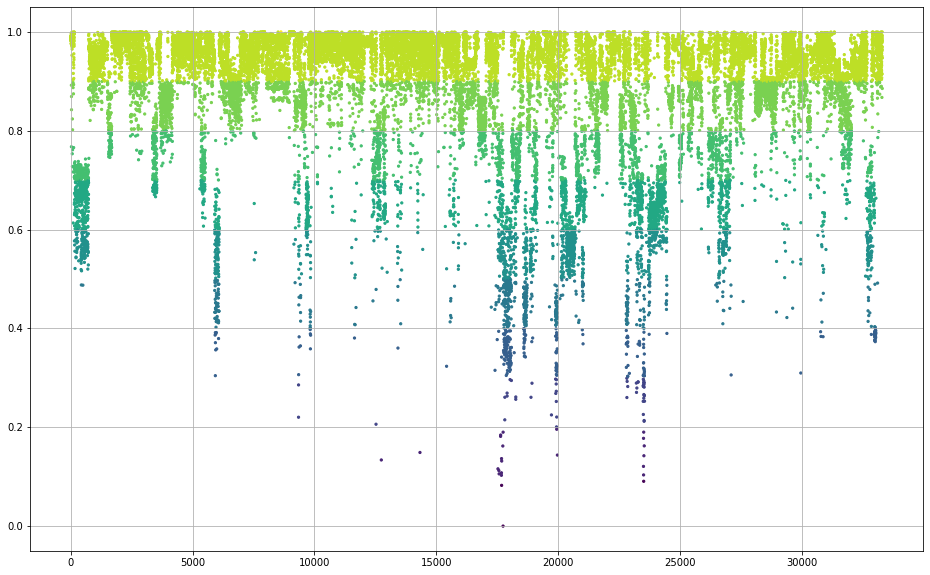

In [59]:
fig, ax = plt.subplots(figsize=(16,10))
im=ax.scatter(x=df.index,y=P,c=np.multiply(P,10).astype(int),s=5)
ax.grid(True)
plt.show()

In [60]:
#estimator.explain_outlier(1000)

#### Feature Importance

In [61]:
warnings.filterwarnings('ignore')
#k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1))
k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, nsamples=1000, random_state=1))
X_test_sample=shap.sample(X_test,random_state=1)
k_shap_values = k_explainer.shap_values(X_test_sample) # More Sample Need more time
warnings.filterwarnings('once')

  0%|          | 0/100 [00:00<?, ?it/s]

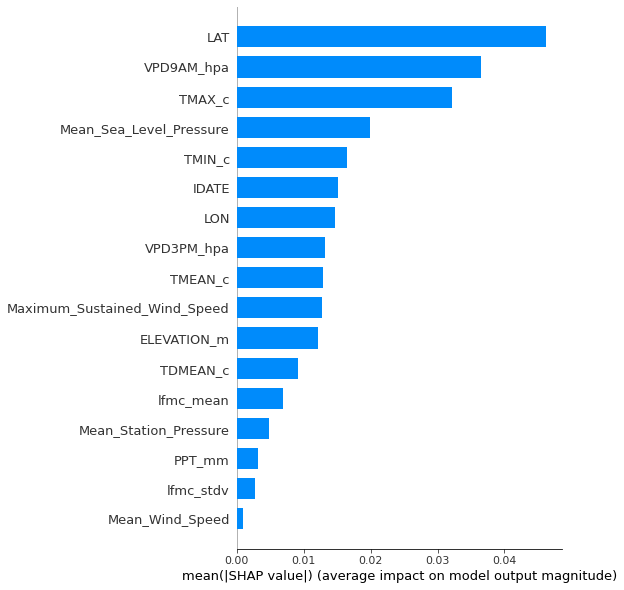

In [62]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample, plot_type="bar")

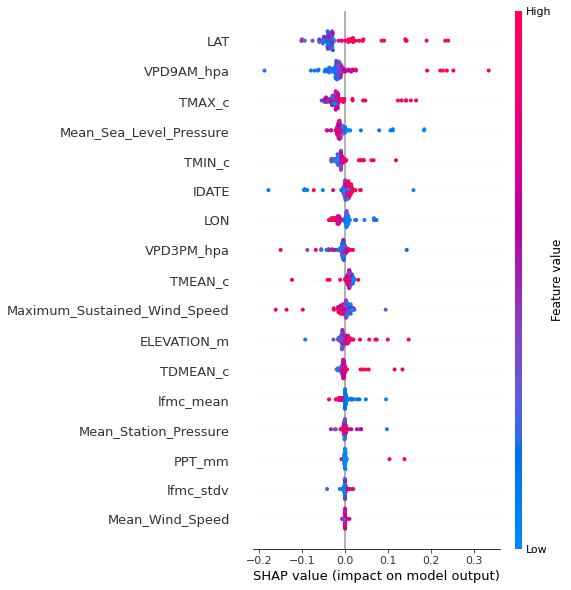

In [63]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample)

In [64]:
shap.initjs()
shap.force_plot(k_explainer.expected_value, k_shap_values, X_test_sample)

In [65]:
feature_names = X_train.columns
rf_resultX = pd.DataFrame(k_shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
#shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
0,IDATE,0.015173
1,LAT,0.046230
2,LON,0.014686
3,ELEVATION_m,0.012104
4,PPT_mm,0.003183
5,TMIN_c,0.016479
6,TMEAN_c,0.012868
7,TMAX_c,0.032209
8,TDMEAN_c,0.009168
9,lfmc_mean,0.006892
